In [224]:
import pandas as pd
import pandas_gbq
import praw
import numpy as np
from prawcore import PrawcoreException
import datetime
import json
import disinfo as di
import matplotlib.pyplot as plt


In [225]:
with open("../gcp_config.json") as f:
    config = json.load(f)

project_id = config["project_id"]
table_sub  = config["table_sub"]
table_com  = config["table_com"]

comments_number = config["comments_number"]
topics_list = config["topics_list"]

client_id = config["client_id"]
client_secret = config["client_secret"]
user_agent =  config["user_agent"]

In [226]:
# Get the data and format the date
# The following line gets ALL the data, beware! 
SQL = f'SELECT * FROM {table_sub}'

df = pandas_gbq.read_gbq(query=SQL, project_id=project_id)

df['created'] = df['created'].dt.date

Downloading: 100%|██████████| 55321/55321 [00:11<00:00, 4740.70rows/s]


In [227]:
# Create a dataframe which contains a count of how many submission per day per subredit there are
posts_per_day = {"day": [],
                 "subreddit": [],
                 "count": [] }

subs = df["subreddit"].unique()

for sub in subs:
    sub_filter = df[df['subreddit'] == sub ]
    days = sub_filter['created'].unique()
    for i in days:
        subs_per_day = sub_filter[sub_filter['created'] == i ]
        subs_per_day_count = subs_per_day.shape[0]
        posts_per_day["count"].append(subs_per_day_count)
        posts_per_day["day"].append(i)
        posts_per_day["subreddit"].append(sub)

In [228]:
data = pd.DataFrame(posts_per_day)


# What is the max and min number of submissions per day?

In [229]:
data['count'].max()

220

In [230]:
data['count'].min()

1

In the current data set the max number of submissions per day is 220 (above) which means that if run daily the data ingest would not need to collect more than 220 per subreddit. However this is because the data ingest was run at 220, so there may be more which havenot been collected

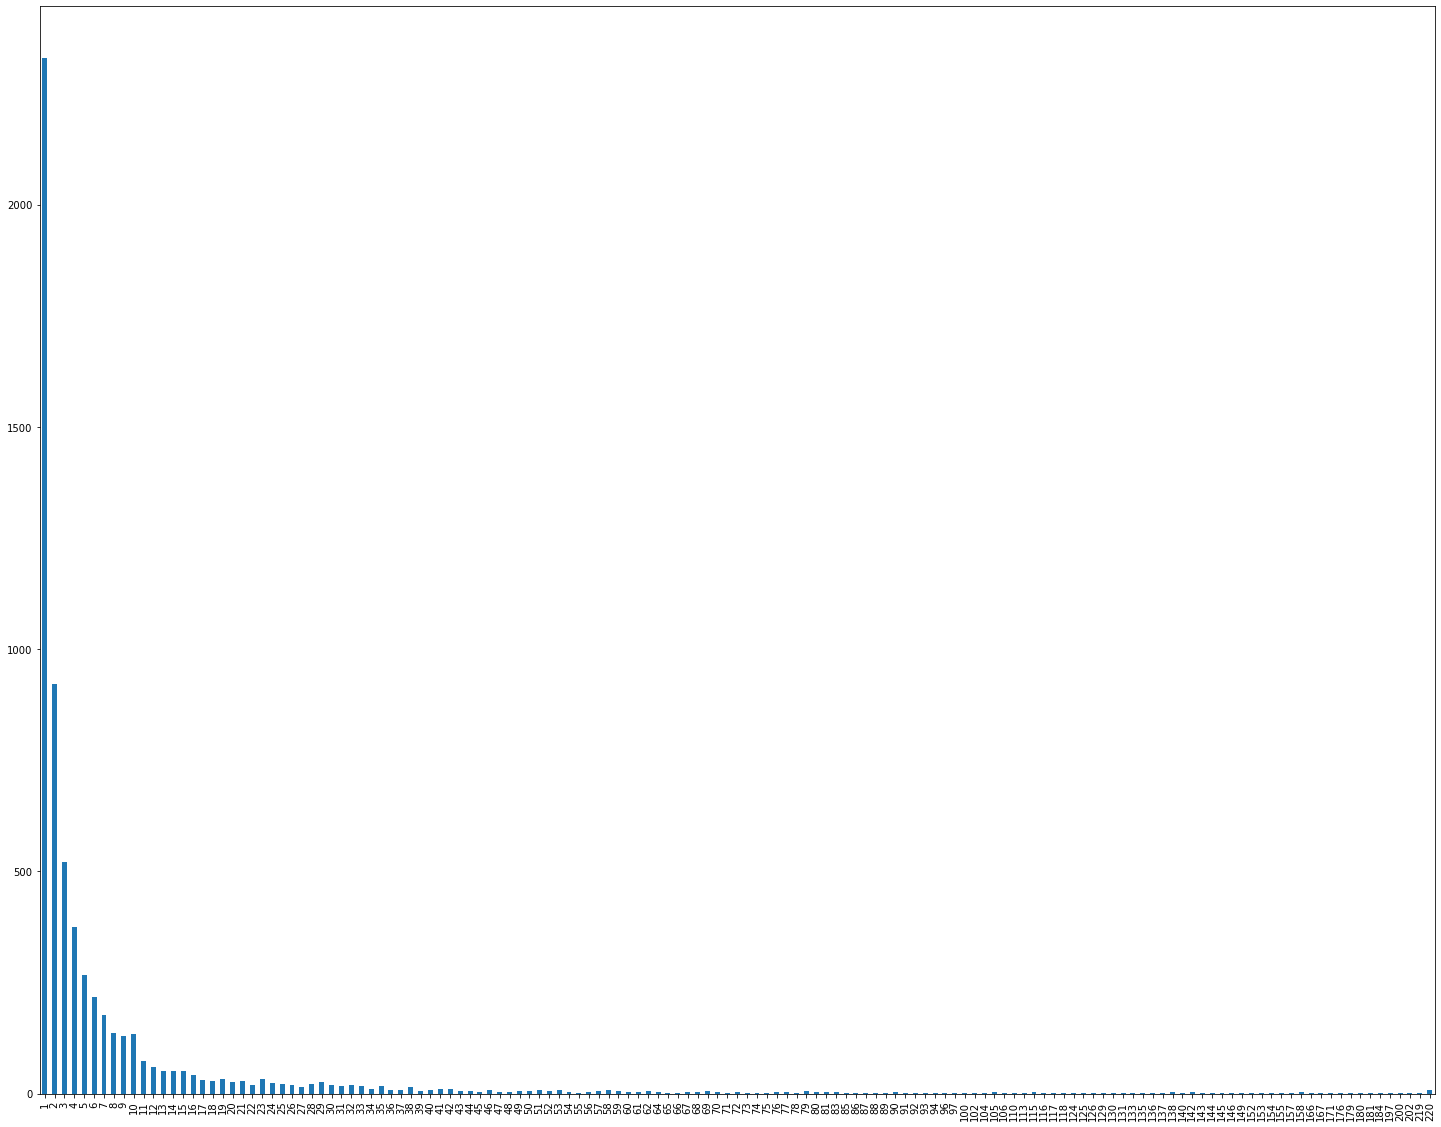

In [231]:
counts = data['count'].value_counts().sort_index(axis=0)

counts.plot(kind='bar', figsize=(25,20))


In [232]:
print(f"The percertage of submissions which are less than 100 a day { counts[counts.index < 100].sum() / counts.sum() * 100 }")

The percertage of submissions which are less than 100 a day 98.72672290307179


In [233]:
print(f"The percertage of submissions which are less than 10 a day { counts[counts.index < 10].sum() / counts.sum() * 100 }")

The percertage of submissions which are less than 10 a day 80.70985198153748


In [234]:
print(f"The percertage of submissions which are less than 1 a day { counts[counts.index == 1].sum() / counts.sum() * 100 }")

The percertage of submissions which are less than 1 a day 37.06827948432277


With the current data if we set the number of submissions to be collect at 100 we will collect almost 99% fo the data, and even at 10 a day we get over 80%. 

> This is dependent on the current data, once we have more data this may change